In [2]:
import numpy
import math
import os
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

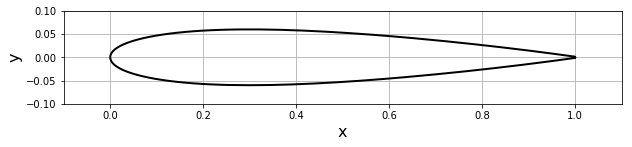

In [3]:
# import the naca airfoil
naca_filepath = os.path.join('naca0012.dat')
# we did this so that you can use this file on windows or linux
with open (naca_filepath, 'r') as file_name:
    x,y = numpy.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)
    
# plot it up
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

In [4]:
# define the panel class slightly differently

class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, xa
        
        self.xc, self.yc = (xa +xb)/2, (ya +yb)/2
        self.length  = math.sqrt((xb-xa)**2+(yb-ya)**2)
        
        # orientation of the panel
        if xb - xa <= 0.0:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb - xa > 0.0:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0 # tangential velocity
        self.cp = 0.0 # pressure coefficient

In [6]:
# we want to get uneven panel distribution along the airfoil surface 
# so use a circle whos diameter is the airfoil's chord length

def define_panels(x,y,N=40):
    # define the circle and its coordinates
    R = (x.max() - x.min())/2
    x_center = (x.max()+x.min())/2
    x_circle = x_center + R*numpy.cos(numpy.linspace(0.0, 2*math.pi, N+1))
    
    x_ends = numpy.copy(x_circle) # project x-coordinates onto the surface
    y_ends = numpy.empty_like(x_ends) # create the y-coordinates
    x,y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    # compute the y-coordinate of the end points
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I]) / (x[I+1]-x[I])
        b = y[I+1]-a*x[I+1]
        y_ends[i] = a*x_ends[i]+b
    y_ends[N] = y_ends[0]
        
    panels = numpy.empty(N, dtype=object)
    for i in range (N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
            
    return panels

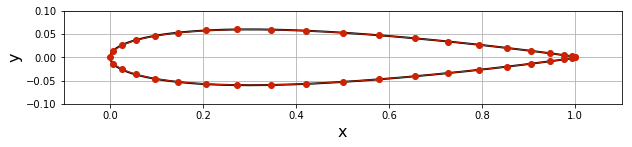

In [7]:
# call the function to map the circle onto the airfoil

N=40 # number of panels
panels = define_panels(x,y,N) # discretize the geometry into panels

# plot it
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

Now we want to create the free stream

Note: we use u_inf = 1 in most cases, but we could use any number. However, because we are using the assumptions of potential flow, we won't asee any separation or any real changes in the streamlines. We may see differences in the Cp values if we don't change the Cp limits in the plot. The things that will be different are the strengths of the source sheets on the panels, as they will need to increase if the freestream velocity increases. 

In [9]:
# create the freestream

class Freestream:
    def __init__(self, u_inf = 1.0, alpha = 0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)
        
u_inf = 1.0 # freestream velocity
alpha = 0.0 # angle of attack
freestream = Freestream(u_inf, alpha) # create the object freestream

In [10]:
# create the flow tangency boundary condition where normal velocity = 0

def integral(x, y, panel, dxdz, dydz):
    def integrand(s):
        return (((x - (panel.xa - math.sin(panel.beta) * s)) * dxdz +
                 (y - (panel.ya + math.cos(panel.beta) * s)) * dydz) /
                ((x - (panel.xa - math.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + math.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [11]:
# solve the linear system

def build_matrix(panels):
    N = len(panels)
    A = numpy.empty((N,N), dtype = float)
    numpy.fill_diagonal(A, 0.5)
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5 / math.pi*integral(p_i.xc, p_i.yc, p_j, math.cos(p_i.beta), math.sin(p_i.beta))
    return A

def build_rhs(panels, freestream):
    b = numpy.empty(len(panels), dtype = float)
    for i,panel in enumerate(panels):
        b[i] = -freestream.u_inf*math.cos(freestream.alpha - panel.beta)
    return b 

In [12]:
# compute the matrices

A = build_matrix(panels)
b = build_rhs(panels, freestream)

# solve the linear system
sigma = numpy.linalg.solve(A,b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

In [17]:
# find the surface pressure coeff

def get_tangential_velocity(panels, freestream):
    
    N = len(panels)
    A = numpy.empty((N,N), dtype = float)
    numpy.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i!=j:
                A[i,j] = 0.5 / math.pi*integral(p_i.xc, p_i.yc, p_j, -math.sin(p_i.beta), math.cos(p_i.beta))
    b = freestream.u_inf*numpy.sin([freestream.alpha - panel.beta for panel in panels])
    sigma = numpy.array([panel.sigma for panel in panels])
    vt = numpy.dot(A,sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

# compute the tangential velocity
get_tangential_velocity(panels, freestream)

# get the pressure coeff

def get_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

# compute the surface pressure coefficients
get_pressure_coefficient(panels, freestream)

In [19]:
# create the theoretical solution to compare to 
voverVsquared=numpy.array([0.0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411,
                           1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044,
                           0.956, 0.906, 0.0])
#print(voverVsquared)

xtheo=numpy.array([0.0, 0.5, 1.25, 2.5, 5.0, 7.5, 10.0, 15.0, 20.0, 25.0, 30.0,
                   40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 95.0, 100.0])
xtheo /= 100
#print(xtheo)

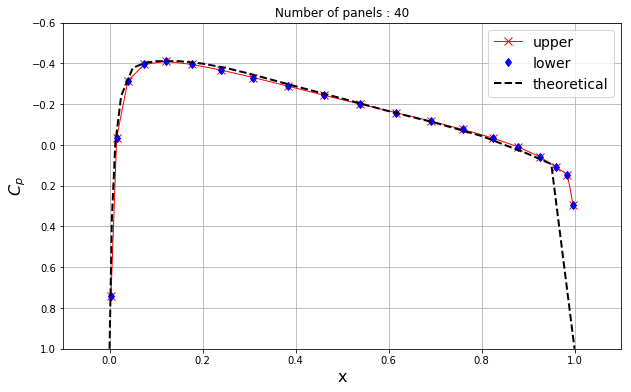

In [20]:
# plot it
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper',
            color='r', linewidth=1, marker='x', markersize=8)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label='lower',
            color='b', linewidth=0, marker='d', markersize=6)
pyplot.plot(xtheo, 1-voverVsquared,
            label='theoretical',
            color='k', linestyle='--',linewidth=2)
pyplot.legend(loc='best', prop={'size':14})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -0.6)
pyplot.title('Number of panels : {}'.format(N));

Here we see that all of the Cp points on the top and bottom of the airfoil surface are the same. This makes sense as the airfoil is symmetric and is at 0 deg angle of attack, so the flow should be symmetric about the top and bottom of the airfoil. 



For the object to be a closed surface we need to check that the sum of all of the source strengths is = 0.

In [21]:
# find the accuracy / is the surface closed

accuracy = sum([panel.sigma*panel.length for panel in panels])
print(' --> sum of the source / sink strengths: {}'.format(accuracy))

 --> sum of the source / sink strengths: 0.004617031175283104


In [24]:
# create the streamlines using the velocity in the u and v directions

def get_velocity_field(panels, freestream, X, Y):
    
    u = freestream.u_inf*math.cos(freestream.alpha)*numpy.ones_like(X,dtype=float)
    v = freestream.u_inf*math.sin(freestream.alpha)*numpy.ones_like(X, dtype=float)
    
    vec_integral = numpy.vectorize(integral)
    for panel in panels:
        u = u + panel.sigma / (2.0*math.pi)*vec_integral(X,Y,panel, 1.0, 0.0)
        v = v + panel.sigma / (2.0*math.pi)*vec_integral(X,Y,panel, 0.0, 1.0)
    
    return u, v

# create the mesh grid
nx, ny = 20,20
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx), \
                      numpy.linspace(y_start, y_end, ny))

# Compute the velocity feild
u, v = get_velocity_field(panels, freestream, X, Y)

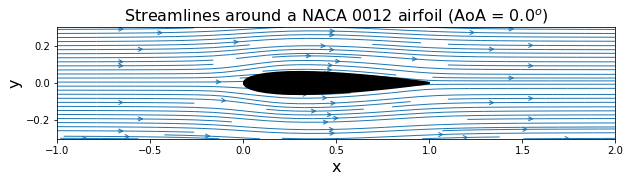

In [25]:
# plot it
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(alpha),
             fontsize=16);

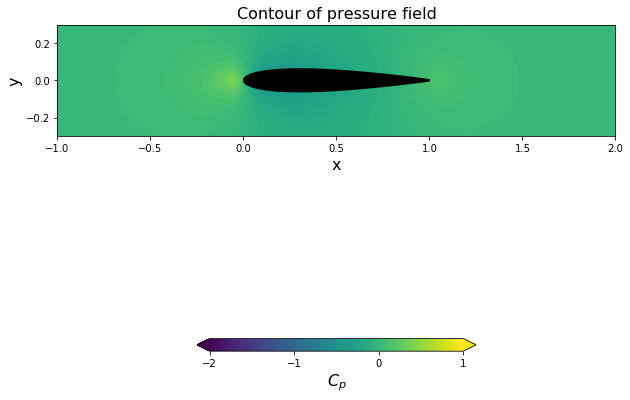

In [26]:
# compute the pressure feild
cp = 1.0 - (u**2+v**2) / freestream.u_inf**2

# plot it
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp,
                        levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Contour of pressure field', fontsize=16);